# Benchmarking `gpujpeg` 📊

In [ ]:
%run benchmark_gpujpeg_LoLa.py

# 📈 Data Visualization & Analysis

Now we will plot the collected data to understand the results. We will focus on:
1.  **Rate-Distortion:** How do quality metrics (like VMAF) change with file size?
2.  **Quality vs. File Size:** How does the `-quality` setting impact file size for different subsampling methods?
3.  **Encoding Performance:** Which Format method is fastest? How does resolution affect encoding time?
4.  **Decoding Performance:** How does resolution affect decoding time?

In [1]:
# --- Main Configuration ---
# Resolutions to test (Name: (Width, Height))
RESOLUTIONS = {
    '1280x720': (1280, 720),
    '1920x1080': (1920, 1080),
    '3840x2160': (3840, 2160),
}

RESOLUTION_TO_FILENAME = {
    '1280x720': 'frame_hd.rgb',
    '1920x1080': 'frame_fullhd.rgb',
    '3840x2160': 'frame_ultrahd.rgb',
}

# Parameters to benchmark
QUALITIES = range(10, 101, 1)
FORMATS = ['planar', 'interleaved']
SUBSAMPLINGS = ['4:4:4', '4:2:2', '4:2:0']
RESTART_INTERVALS = [0, 1, 2, 4, 8, 16, 32, 64, 128]

SUBSAMPLING_TO_PARAM = {
    '4:4:4': '444',
    '4:2:2': '422',
    '4:2:0': '420'
}

In [2]:
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df = pd.read_csv('results_gpujpeg_LoLa.csv')
df.head()

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
0,1280x720,10,interleaved,8,4:2:0,100,0.000462,0.214618,0.001084,0.000413,0.119170,0.000870,43.094,27.668692,0.795669,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
1,1280x720,11,interleaved,8,4:2:0,100,0.000441,0.118025,0.001060,0.000423,0.114598,0.000861,45.220,28.071320,0.805990,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
2,1280x720,12,interleaved,8,4:2:0,100,0.000445,0.114748,0.000583,0.000425,0.114215,0.000868,47.165,28.397966,0.815485,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
3,1280x720,13,interleaved,8,4:2:0,100,0.000445,0.120664,0.001079,0.000426,0.125009,0.000854,49.191,28.713205,0.824429,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
4,1280x720,14,interleaved,8,4:2:0,100,0.000449,0.117909,0.001079,0.000431,0.124092,0.000860,51.030,28.941029,0.831012,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [23]:
# Set plot style
sns.set_theme(style="whitegrid")

## Encoding Parameters vs. quality metrics

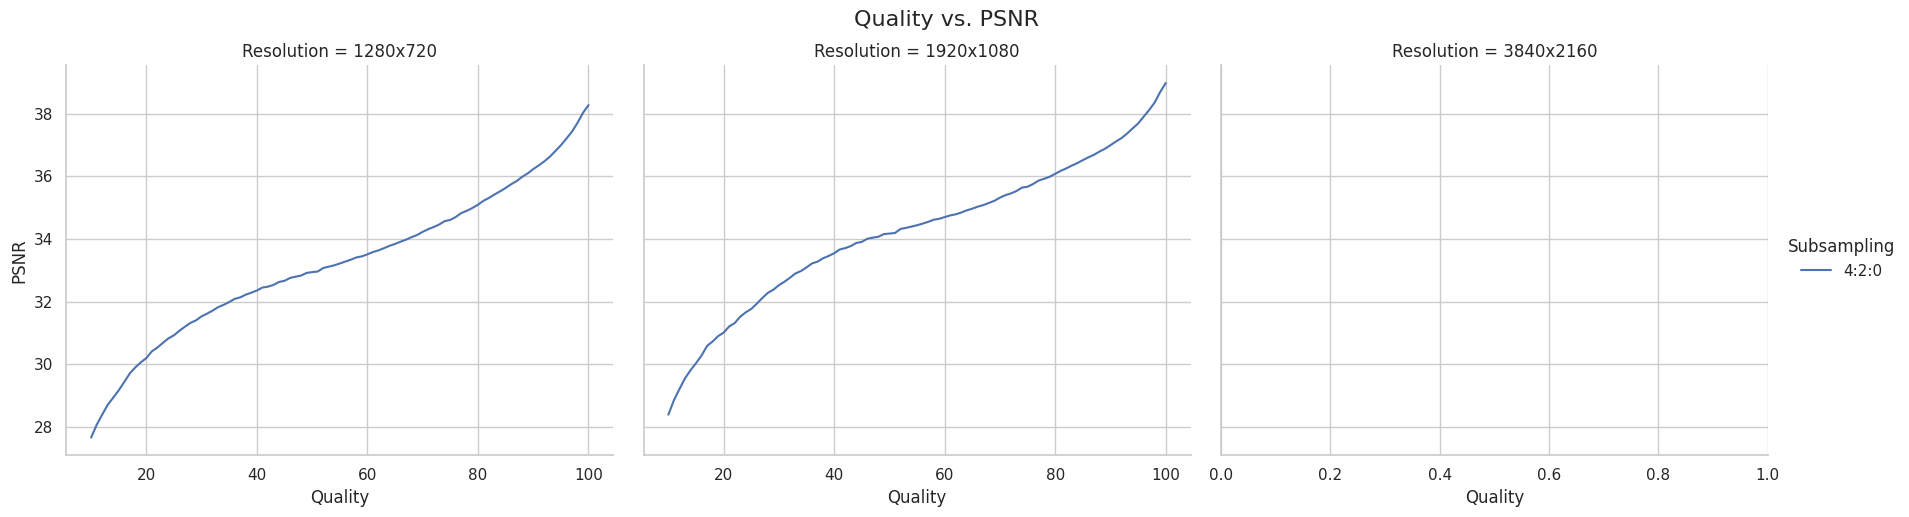

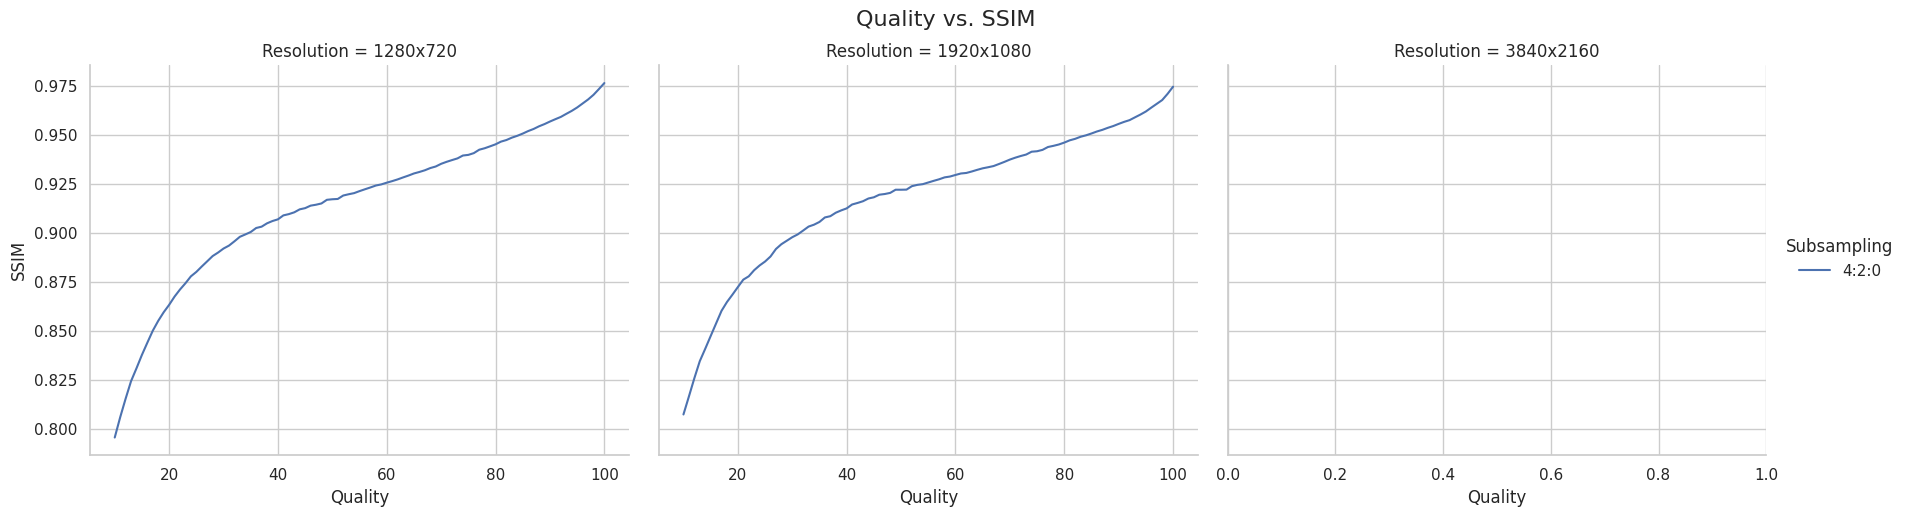

In [24]:
x = 'Quality'
y = 'PSNR'

g = sns.relplot(
    data=df,
    x=x,
    y=y,
    hue='Subsampling',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharex': False}
)

g.figure.suptitle(f'{x} vs. {y}', y=1.03, fontsize=16)
g.set_axis_labels(x, y)
plt.show()

x = 'Quality'
y = 'SSIM'

g = sns.relplot(
    data=df,
    x=x,
    y=y,
    hue='Subsampling',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharex': False}
)

g.figure.suptitle(f'{x} vs. {y}', y=1.03, fontsize=16)
g.set_axis_labels(x, y)
plt.show()

## Encoding Parameters vs. File Size


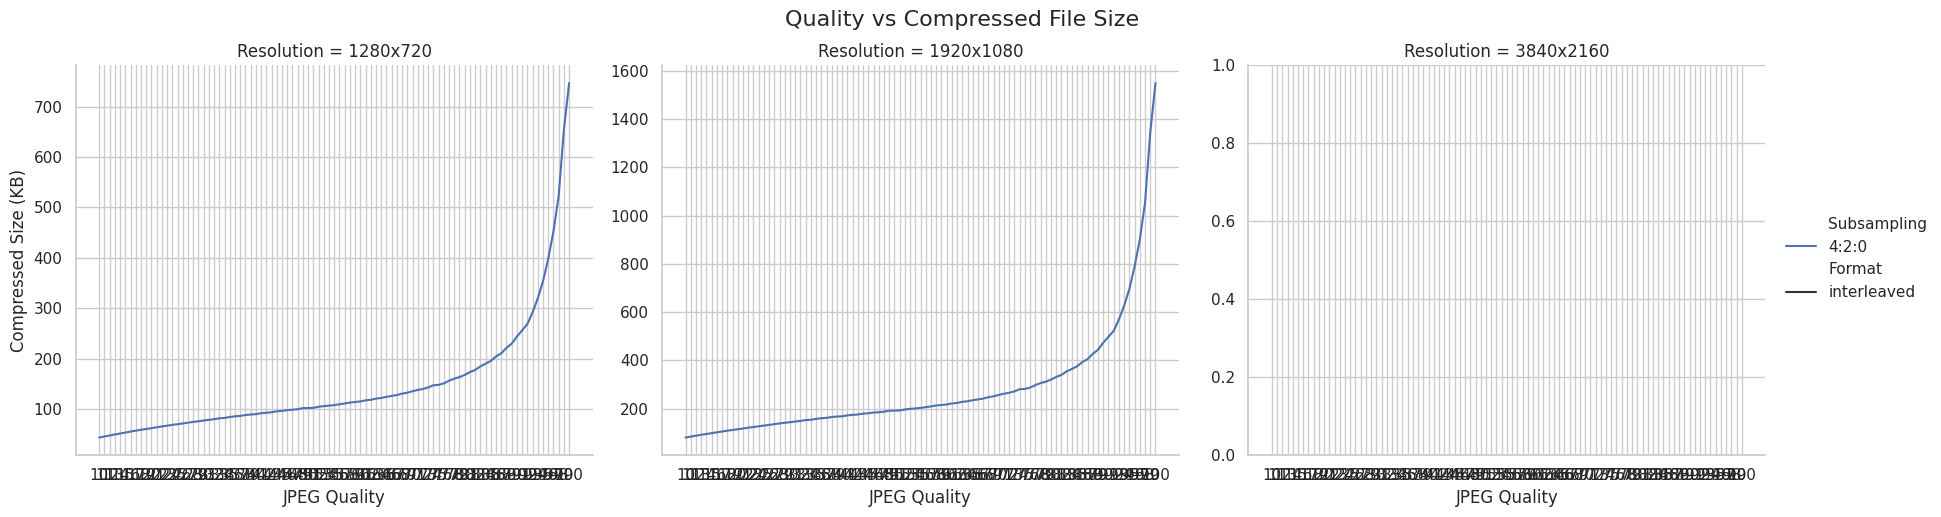

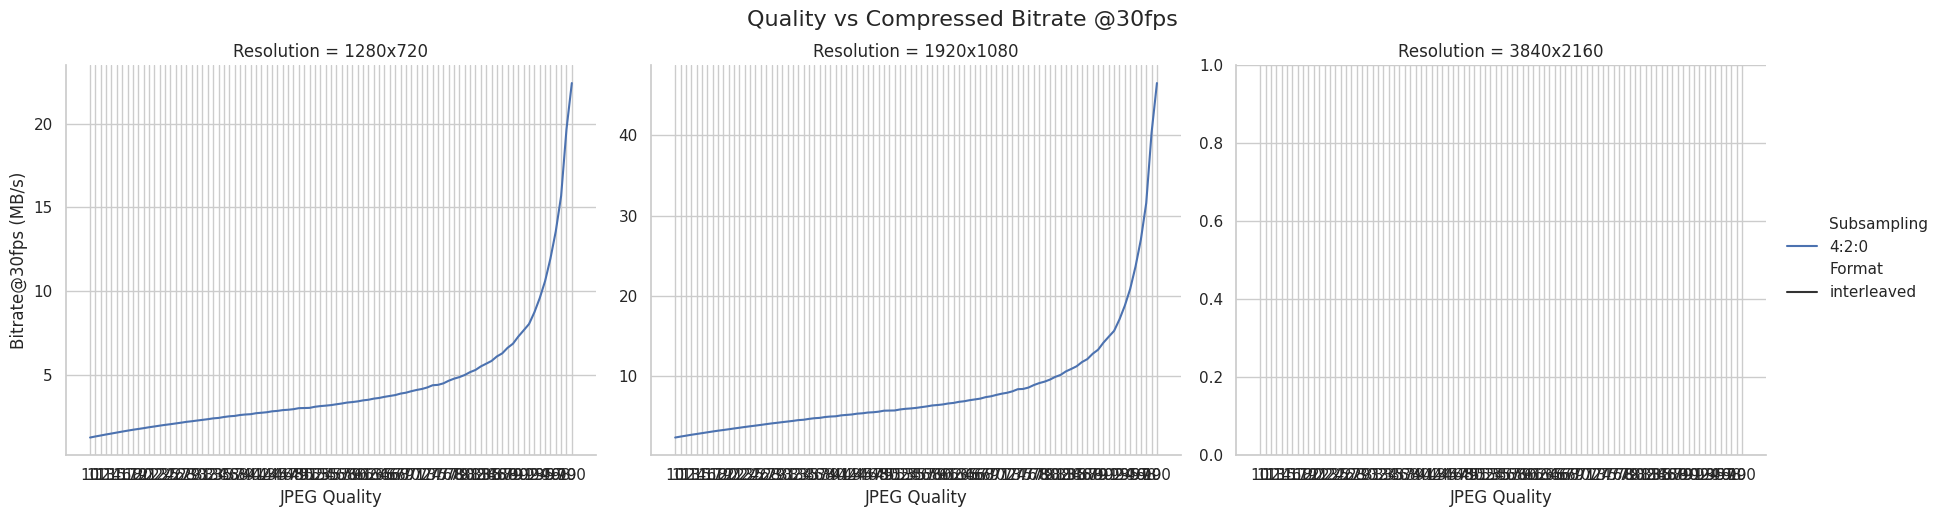

In [25]:
g = sns.relplot(
    data=df,
    x='Quality',
    y='Compressed Size (KB)',
    hue='Subsampling',
    style='Format',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Compressed File Size', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Compressed Size (KB)')
g.set(xticks=QUALITIES)
plt.show()

fps = 30
g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Compressed Size (KB)'] * fps / 1000,
    hue='Subsampling',
    style='Format',
    col='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    col_order=RESOLUTIONS.keys(),
    facet_kws={'sharey': False},
)
g.figure.suptitle(f'Quality vs Compressed Bitrate @{fps}fps', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', f'Bitrate@{fps}fps (MB/s)')
g.set(xticks=QUALITIES)
plt.show()

We can observe an explosion in file size from quality 95 onwards, and a sharp increase from quality 90 onwards.

## Encoding Parameters vs. Performance

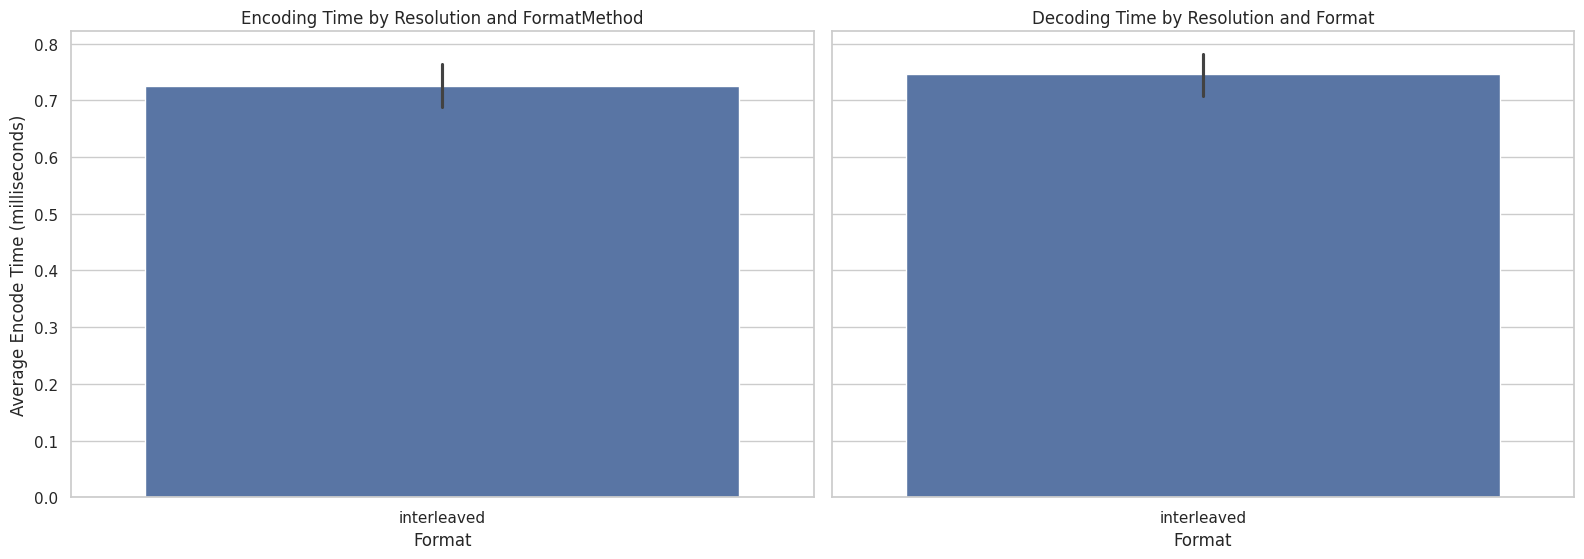

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot 1: Encoding time by Resolution and Format
#method
sns.barplot(
    data=df,
    x='Format',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_title('Encoding Time by Resolution and FormatMethod')
ax[0].set_ylabel('Average Encode Time (milliseconds)')
ax[0].set_xlabel('Format')
# Plot 2: Decoding time by Resolution and Format
#method
sns.barplot(
    data=df,
    x='Format',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_title('Decoding Time by Resolution and Format')
ax[1].set_ylabel('Average Decode Time (milliseconds)')
ax[1].set_xlabel('Format')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
plt.show()

In [27]:
df = df[df['Format'] == 'interleaved']

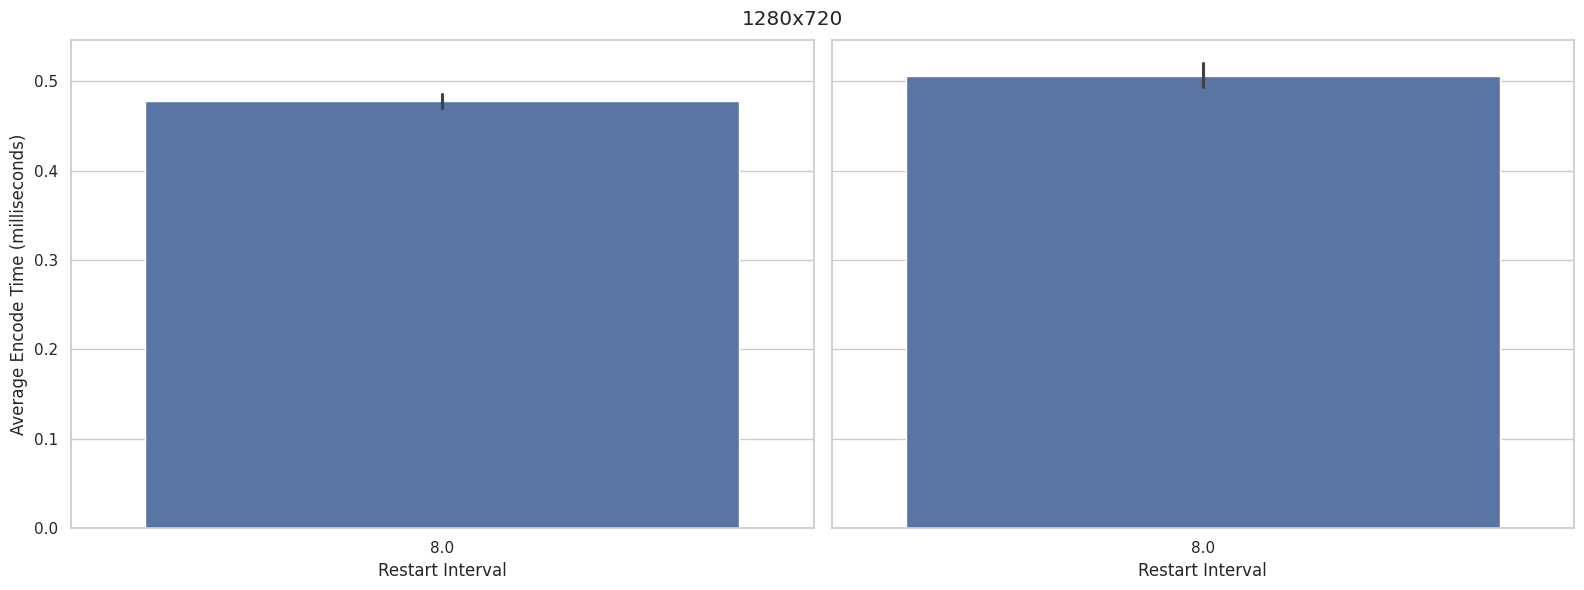

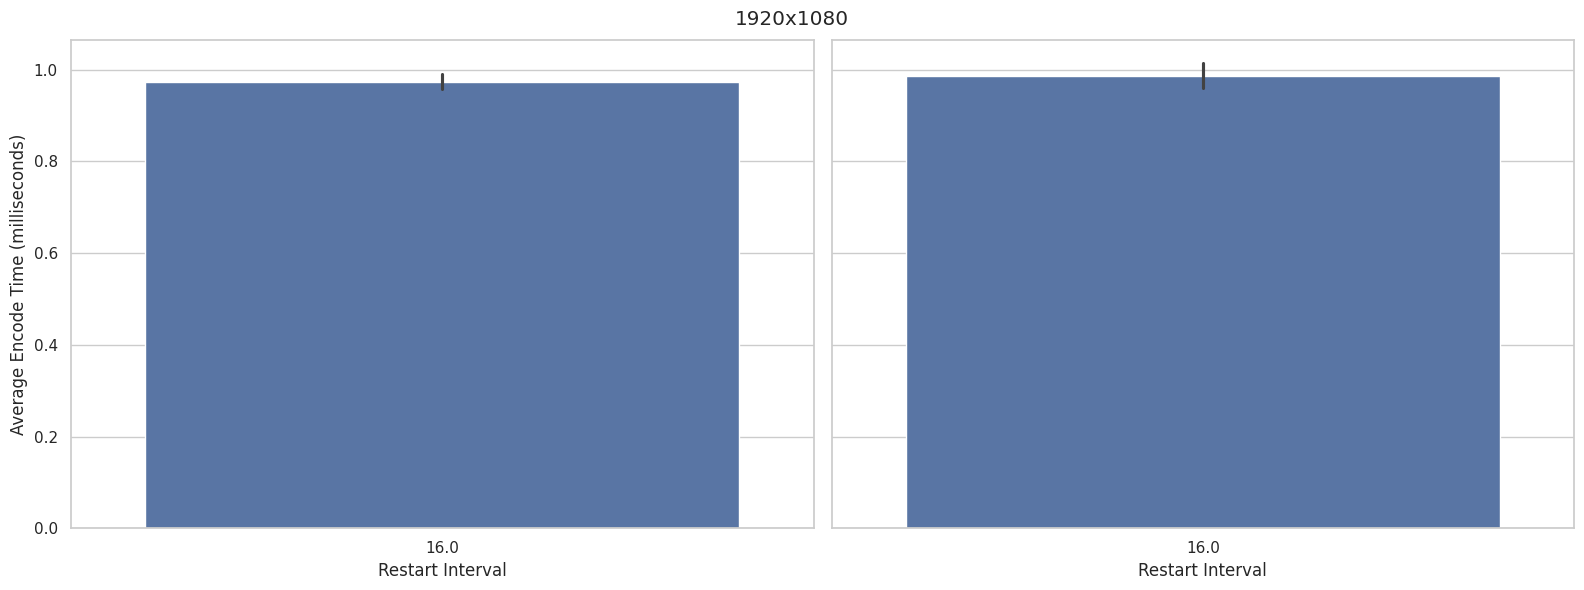

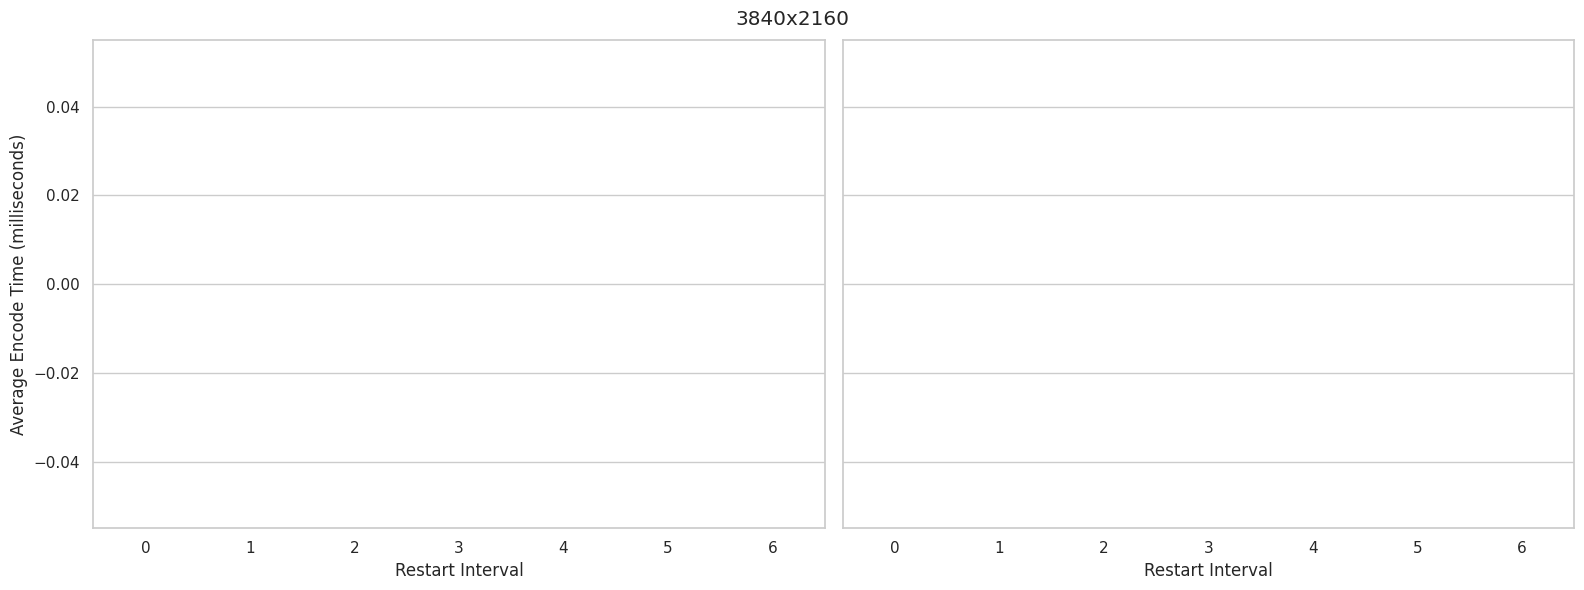

In [28]:
# 1280x720
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Restart interval method
sns.barplot(
    data=df[df['Resolution'] == '1280x720'],
    x='Restart Interval',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_ylabel('Average Encode Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.barplot(
    data=df[df['Resolution'] == '1280x720'],
    x='Restart Interval',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_ylabel('Average Encode Time (milliseconds)')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
fig.suptitle("1280x720")
plt.show()

# 1920x1080
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Restart interval method
sns.barplot(
    data=df[df['Resolution'] == '1920x1080'],
    x='Restart Interval',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_ylabel('Average Encode Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.barplot(
    data=df[df['Resolution'] == '1920x1080'],
    x='Restart Interval',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_ylabel('Average Encode Time (milliseconds)')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
fig.suptitle("1920x1080")
plt.show()

# 3840x2160
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Restart interval method
sns.barplot(
    data=df[df['Resolution'] == '3840x2160'],
    x='Restart Interval',
    y=df['Avg Encode Time (s)'] * 1000,
    ax=ax[0]
)
ax[0].set_ylabel('Average Encode Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.barplot(
    data=df[df['Resolution'] == '3840x2160'],
    x='Restart Interval',
    y=df['Avg Decode Time (s)'] * 1000,
    ax=ax[1]
)
ax[1].set_ylabel('Average Encode Time (milliseconds)')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
fig.suptitle("3840x2160")
plt.show()

In [29]:
df = df[df['Restart Interval'] > 0]

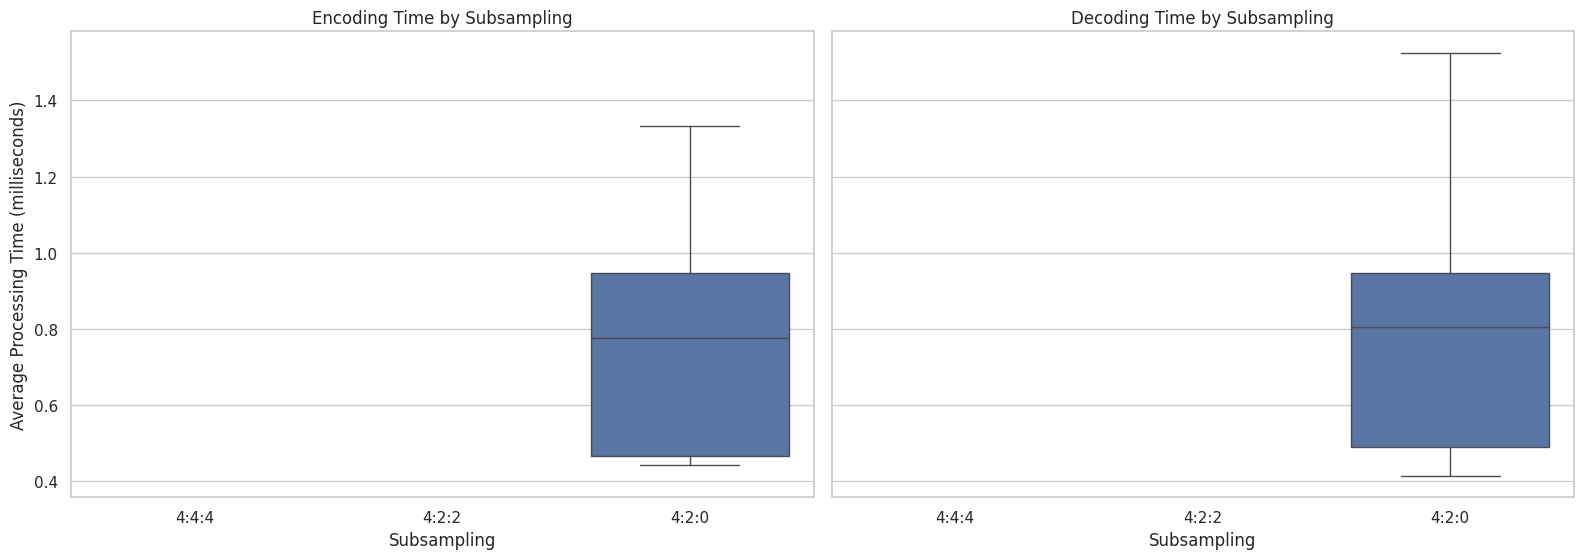

In [30]:
## Encoding Parameters vs. Performance
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# Plot #1: Encoding time by Subsampling method
sns.boxplot(
    data=df,
    x='Subsampling',
    y=df['Avg Encode Time (s)'] * 1000,
    order=SUBSAMPLINGS,
    ax=ax[0]
)
ax[0].set_title('Encoding Time by Subsampling')
ax[0].set_ylabel('Average Processing Time (milliseconds)')

# Plot #2: Decoding time by Subsampling method
sns.boxplot(
    data=df,
    x='Subsampling',
    y=df['Avg Decode Time (s)'] * 1000,
    order=SUBSAMPLINGS,
    ax=ax[1]
)
ax[1].set_title('Decoding Time by Subsampling')
plt.tight_layout(rect=[0.0, 0.0, 1.0, 0.96])
plt.show()

In [31]:
df = df[df['Subsampling'] == "4:2:0"]

In [32]:
df_hd = df[(df['Restart Interval'] == 8) & (df['Resolution'] == "1280x720")]
df_fullhd = df[(df['Restart Interval'] == 16) & (df['Resolution'] == "1920x1080")]
df_ultrahd = df[(df['Restart Interval'] == 32) & (df['Resolution'] == "3840x2160")]
df = df[((df['Restart Interval'] == 8) & (df['Resolution'] == "1280x720")) | ((df['Restart Interval'] == 16) & (df['Resolution'] == "1920x1080")) | ((df['Restart Interval'] == 32) & (df['Resolution'] == "3840x2160"))]

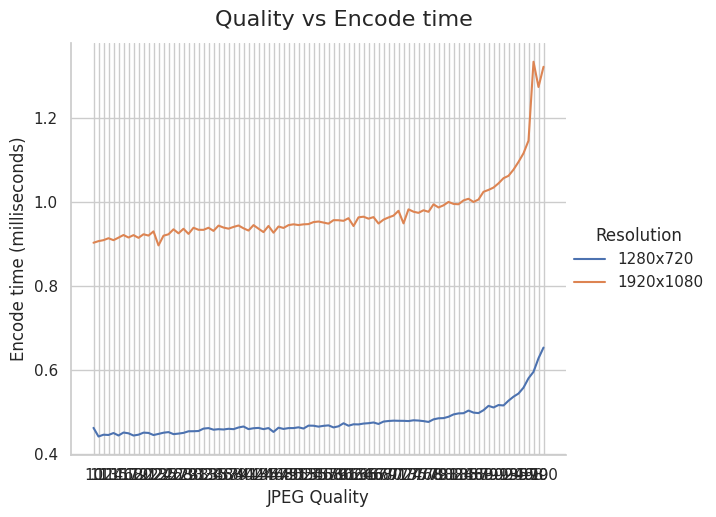

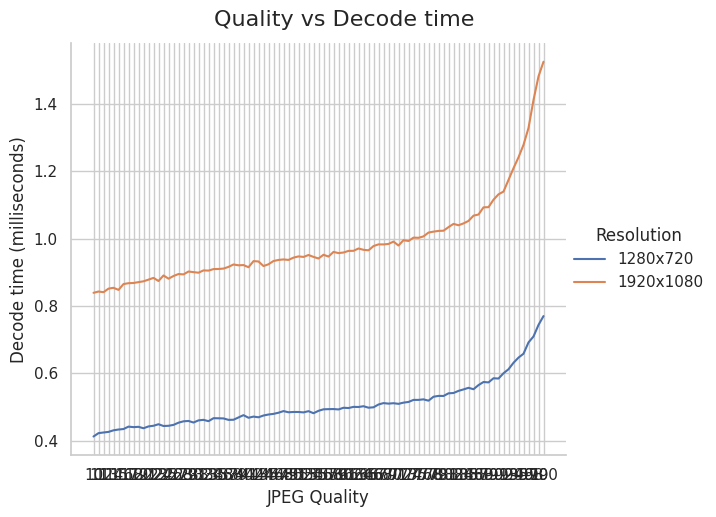

In [33]:
g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Avg Encode Time (s)'] * 1000,
    hue='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Encode time', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Encode time (milliseconds)')
g.set(xticks=QUALITIES)
plt.show()

g = sns.relplot(
    data=df,
    x='Quality',
    y=df['Avg Decode Time (s)'] * 1000,
    hue='Resolution',
    kind='line',
    height=5,
    aspect=1.2,
    facet_kws={'sharey': False}
)
g.figure.suptitle('Quality vs Decode time', y=1.03, fontsize=16)
g.set_axis_labels('JPEG Quality', 'Decode time (milliseconds)')
g.set(xticks=QUALITIES)
plt.show()

In [34]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 2 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 2]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 2]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
90,1280x720,100,interleaved,8,4:2:0,100,0.000653,0.115080,0.001110,0.000770,0.114262,0.000884,747.017,38.277729,0.976556,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
181,1920x1080,100,interleaved,16,4:2:0,100,0.001321,0.116285,0.000701,0.001526,0.115138,0.001187,1549.335,38.980778,0.974701,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
89,1280x720,99,interleaved,8,4:2:0,100,0.000627,0.113842,0.000610,0.000744,0.113508,0.000857,655.163,38.028576,0.973485,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
180,1920x1080,99,interleaved,16,4:2:0,100,0.001273,0.115000,0.001655,0.001482,0.114138,0.001145,1343.655,38.696690,0.971084,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
88,1280x720,98,interleaved,8,4:2:0,100,0.000595,0.115775,0.001066,0.000710,0.114555,0.000873,522.892,37.706879,0.970533,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [35]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 1.5 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 1.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 1.5]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
90,1280x720,100,interleaved,8,4:2:0,100,0.000653,0.115080,0.001110,0.000770,0.114262,0.000884,747.017,38.277729,0.976556,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
181,1920x1080,100,interleaved,16,4:2:0,100,0.001321,0.116285,0.000701,0.001526,0.115138,0.001187,1549.335,38.980778,0.974701,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
89,1280x720,99,interleaved,8,4:2:0,100,0.000627,0.113842,0.000610,0.000744,0.113508,0.000857,655.163,38.028576,0.973485,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
180,1920x1080,99,interleaved,16,4:2:0,100,0.001273,0.115000,0.001655,0.001482,0.114138,0.001145,1343.655,38.696690,0.971084,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
88,1280x720,98,interleaved,8,4:2:0,100,0.000595,0.115775,0.001066,0.000710,0.114555,0.000873,522.892,37.706879,0.970533,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [36]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 1 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 1]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 1]
df[df['Resolution'] == '1280x720'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
90,1280x720,100,interleaved,8,4:2:0,100,0.000653,0.115080,0.001110,0.000770,0.114262,0.000884,747.017,38.277729,0.976556,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
89,1280x720,99,interleaved,8,4:2:0,100,0.000627,0.113842,0.000610,0.000744,0.113508,0.000857,655.163,38.028576,0.973485,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
88,1280x720,98,interleaved,8,4:2:0,100,0.000595,0.115775,0.001066,0.000710,0.114555,0.000873,522.892,37.706879,0.970533,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
87,1280x720,97,interleaved,8,4:2:0,100,0.000580,0.113568,0.001077,0.000692,0.113695,0.000864,452.533,37.426098,0.968149,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
86,1280x720,96,interleaved,8,4:2:0,100,0.000557,0.118816,0.000588,0.000659,0.115385,0.000877,398.447,37.207790,0.966119,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [37]:
df[df['Resolution'] == '1920x1080'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
158,1920x1080,77,interleaved,16,4:2:0,100,0.000976,0.113196,0.001667,0.001018,0.121294,0.001130,297.407,35.868687,0.943917,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
157,1920x1080,76,interleaved,16,4:2:0,100,0.000980,0.119365,0.001656,0.001007,0.113374,0.001139,287.113,35.760185,0.942458,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
156,1920x1080,75,interleaved,16,4:2:0,100,0.000974,0.115681,0.000670,0.001003,0.113511,0.001134,281.336,35.673470,0.941759,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
155,1920x1080,74,interleaved,16,4:2:0,100,0.000976,0.113972,0.001640,0.001003,0.117484,0.001191,280.214,35.645634,0.941523,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
154,1920x1080,73,interleaved,16,4:2:0,100,0.000982,0.120379,0.002784,0.000993,0.117476,0.001144,271.408,35.535374,0.940081,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [38]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 0.5 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 0.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 0.5]
df[df['Resolution'] == '1280x720'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
67,1280x720,77,interleaved,8,4:2:0,100,0.000476,0.118082,0.001082,0.000519,0.114468,0.000855,155.865,34.834362,0.942539,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
63,1280x720,73,interleaved,8,4:2:0,100,0.000478,0.115363,0.001074,0.000515,0.127761,0.000862,142.538,34.468460,0.938105,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
62,1280x720,72,interleaved,8,4:2:0,100,0.000478,0.114217,0.000578,0.000513,0.120081,0.000860,139.532,34.387882,0.937250,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
61,1280x720,71,interleaved,8,4:2:0,100,0.000479,0.119447,0.001066,0.000510,0.114472,0.000853,137.526,34.318287,0.936359,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
60,1280x720,70,interleaved,8,4:2:0,100,0.000479,0.114529,0.001064,0.000512,0.114911,0.000880,135.047,34.232830,0.935344,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...


In [39]:
df[df['Resolution'] == '1920x1080'].sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD


In [40]:
df = df[df['Avg Encode Time (s)'] * 1000 + df['Avg Decode Time (s)'] * 1000 <= 0.45 * 2]
#df = df[df['Avg Encode Time (s)'] * 1000 <= 0.5]
#df = df[df['Avg Decode Time (s)'] * 1000 <= 0.5]
df.sort_values(by='SSIM', ascending=False).head(5)

,Resolution,Quality,Format,Restart Interval,Subsampling,Iterations,Avg Encode Time (s),Encoder Setup Time (s),Encoder Cleanup Time (s),Avg Decode Time (s),Decoder Setup Time (s),Decoder Cleanup Time (s),Compressed Size (KB),PSNR,SSIM,Encode CMD,Decode CMD
16,1280x720,26,interleaved,8,4:2:0,100,0.000447,0.121127,0.001045,0.000447,0.121577,0.000852,71.068,31.080294,0.882947,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
15,1280x720,25,interleaved,8,4:2:0,100,0.000452,0.116439,0.001051,0.000445,0.115106,0.000863,69.553,30.932590,0.880184,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
14,1280x720,24,interleaved,8,4:2:0,100,0.000450,0.118752,0.000584,0.000444,0.113806,0.000857,68.205,30.834158,0.877921,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
13,1280x720,23,interleaved,8,4:2:0,100,0.000447,0.115193,0.001072,0.000449,0.114324,0.000854,66.679,30.691746,0.874406,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
12,1280x720,22,interleaved,8,4:2:0,100,0.000445,0.119221,0.001069,0.000445,0.119168,0.000853,65.018,30.541584,0.871210,/home/simone/Documenti/video-compression-laten...,/home/simone/Documenti/video-compression-laten...
